In [ ]:
# Install Software and check its version
! pip install -q 'gwosc==0.5.4'
import gwosc
print(gwosc.__version__)

# #Uncomment this section to install everything once 

# ! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0' 'gwpy==2.0.2'
# ! pip install matplotlib==3.1.3
# # -- Click "restart runtime" in the runtime menu after recommenting all this

0.5.4


In [ ]:
# Packages

from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab

import pycbc.types 
from pycbc.types import TimeSeries

import pycbc.noise

import pycbc.psd
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pycbc.filter
from pycbc.filter import resample_to_delta_t, highpass, matched_filter

import pycbc.waveform
from pycbc.waveform import get_td_waveform


1) Load the data of the LIGO Hanford detector from [2]. Plot the noise power spectral density (PSD) of that data. Test whether there is any gravitational wave signal present in the data or not? For this test, you can assume the GW signals can produce only from equal mass binary systems with a range between 5 to 10. We assume a threshold on matched filter SNR of 8 to claim detection of GW.

In [ ]:
###Load the data of the LIGO Hanford detector from [2]

# from the drive so needs to be retrieved this way
drive.mount('/content/drive')

pycbc_strain = pycbc.types.load_timeseries('/content/drive/MyDrive/GW_noisedata-2.npy')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#solar masses for this exercise
# equal mass range (5, 10)
m = np.arange(5,10,0.1) # Mass range bewteen 5 to  10 (format arguments: start, stop, step)
#m1 = m2 = m

#approximant
apx = "TaylorF2"

#rates
sample_rate = 2048 # samples per second
data_length = 1024 # seconds
delta_t = 1/sample_rate

f_low = 15 #Hz


In [ ]:
# Remove the low frequency content and downsample the data to 2048Hz

pycbc_strain = highpass(pycbc_strain, 15.0)
pycbc_strain = resample_to_delta_t(pycbc_strain, 1.0/2048)

# Condition data = Remove 2 seconds of data from both the beginning and end 
conditioned_strain = pycbc_strain.crop(2,2)


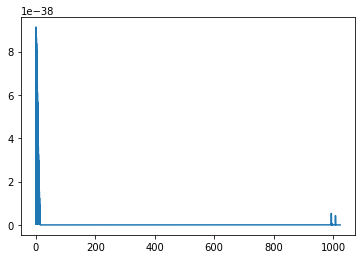

In [ ]:
###Plot the noise power spectral density (PSD) of that data.

#compute PSD and work it out
psd = conditioned_strain.psd(4)

psd = interpolate(psd, conditioned_strain.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * pycbc_strain.sample_rate),
                                  low_frequency_cutoff=f_low)

plt.plot(psd.sample_frequencies, psd)


In [ ]:
#the psd looks weird but does not work otherwise

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


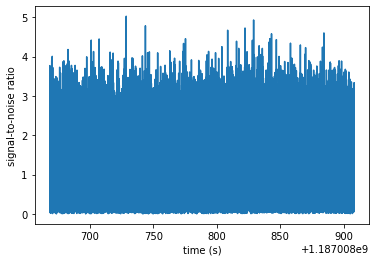

Maximum SNR 5.02322139327992

 We found a signal at 1187008728.679297s with SNR 5.02322139327992


In [ ]:
###Test whether there is any gravitational wave signal present in the data or not? ###

## initialize list first 
SNR_list = np.zeros((len(m), 2), float) #--> create a array of 2 columns that has the number of rows corresponding to the number or tried masses

#Create Loop to go through all values for the mass 
for i in range(0, len(m)):  
  #get the template
  hp, _ = get_td_waveform(approximant=apx,
                          mass1=m[i],
                          mass2=m[i],
                          delta_t=delta_t,
                          f_lower=f_low)
  # Resize the vector to match our data
  hp.resize(len(conditioned_strain))
  #shift the template
  template = hp.cyclic_time_shift(hp.start_time)

  # Compute SNRs time-series
  SNRs = matched_filter(template, 
                      conditioned_strain,
                      psd=psd, 
                      low_frequency_cutoff=f_low)

  # Remove time corrupted by the template filter and the psd filter
  SNRs =SNRs.crop(4 + 4, 4)

  #find the peak and the values corresponding
  peak = abs(SNRs).numpy().argmax() # find the peak (its location in the array)
  snrp = SNRs[peak] # get its SNR value
  time = SNRs.sample_times[peak] # get its location (in time)

  #store the maximum SNR (peak) each time
  SNR_list[i][0] = snrp #the first column in the previously created array is the peak ([i] = for each mass)
  SNR_list[i][1] = time #the second column is the time

# Plotting
pylab.plot(SNRs.sample_times, abs(SNRs))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()
print('Maximum SNR', max(abs(SNRs)))

print("\n We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [ ]:
## there is no gravitational wave signal present in the dat as the matched filter SNR did not pass the threshold of 8.


2) Whiten the above data using its noise PSD. You can use PyCBC based function of the Welch method to estimate the PSD. Construct a histogram of the whitened data and show that the whiten data follows a Gaussian distribution with zero mean.

In [ ]:
##Whiten the above data using its noise PSD
data_whitened = (conditioned_strain.to_frequencyseries() / psd**0.5).to_timeseries()
data_whitened = data_whitened.crop(4 + 4, 4)

In [ ]:
dir(data_whitened)

In [ ]:
##compute the mean to check if it is indeed at 0

sum = data_whitened.sum()
# sum

mean = sum/len(data_whitened)
mean

-0.0004398528481684202

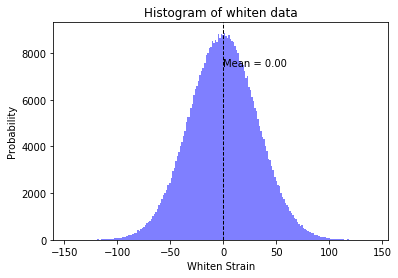

In [ ]:
##build the histogram
num_bins = 200 #set the number of desired bins (the most,  the better)
plt.hist(data_whitened, num_bins, facecolor='blue', alpha=0.5) #create histogram 

min_ylim, max_ylim = plt.ylim()
plt.axvline(x = mean , color='k', linestyle='dashed', linewidth=1) #draw a line at 0 to check if the mean of the withen data is indeed 0 (-0.0004398528481684202)
plt.text((mean), max_ylim*0.8, 'Mean = {:.2f}'.format(round(mean)))

pylab.ylabel('Probability')
pylab.xlabel('Whiten Strain')
pylab.title('Histogram of whiten data')
pylab.show()

In [ ]:
# the histogram of the whiten data does indeed follow a Gaussian distribution with a mean at 0